# San Diego Burrito Analytics: Data characterization

Scott Cole

21 May 2016

This notebook characterizes the collection of reviewers of San Diego burritos including:

1. Metadata
2. How many of each kind of burrito have been reviewed?
3. For each of burrito dimension, what is the distribution of its scores across all samples?

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

### Load data

In [2]:
import util
df = util.load_burritos()
N = df.shape[0]

### Brief metadata

In [3]:
print 'Number of burritos:', df.shape[0]
print 'Number of restaurants:', len(df.Location.unique())
print 'Number of reviewers:', len(df.Reviewer.unique())
print 'Number of reviews by Scott:', df.Reviewer.value_counts()['Scott']
print 'Number of reviews by Emily:', df.Reviewer.value_counts()['Emily']

uniqlocidx = df.Location.drop_duplicates().index
print 'Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/np.float(len(df.Location.unique())),1)

Number of burritos: 157
Number of restaurants: 43
Number of reviewers: 36
Number of reviews by Scott: 59
Number of reviews by Emily: 29
Percentage of taco shops with free chips: 27.9


### What types of burritos have been rated?

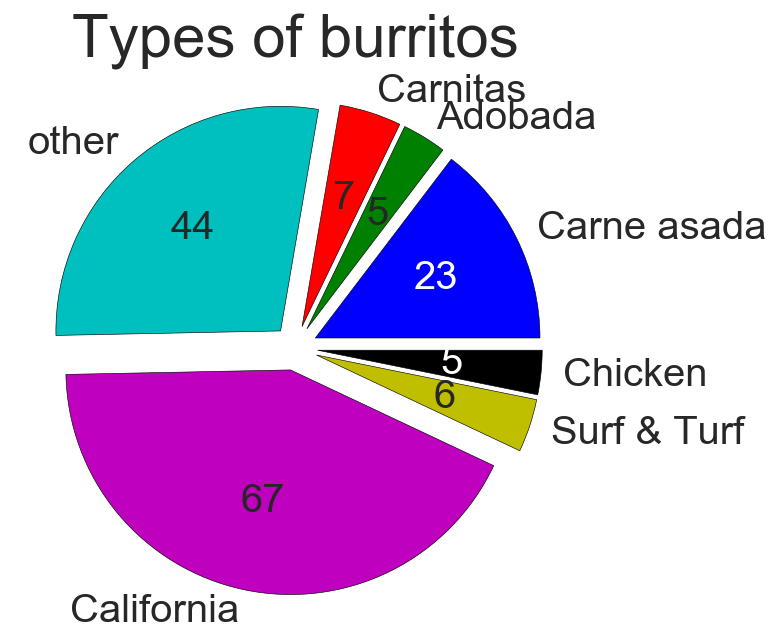

In [4]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = typecounts.values()
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

### Progress in number of burritos rated

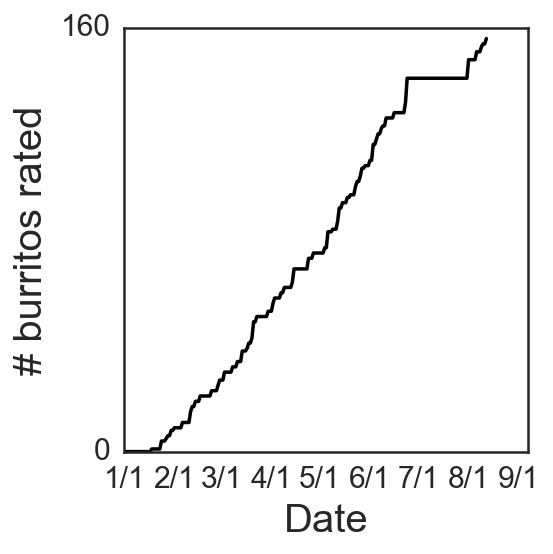

In [12]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(df.Date[d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 9):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels()

plt.figure(figsize=(4,4))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date',size=20)
plt.ylabel('# burritos rated',size=20)
plt.xticks(datets,datestrs,size=15)
plt.yticks((0,int(math.ceil(len(burrdays) / 10.0)) * 10),size=15)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

# Burrito dimension distributions

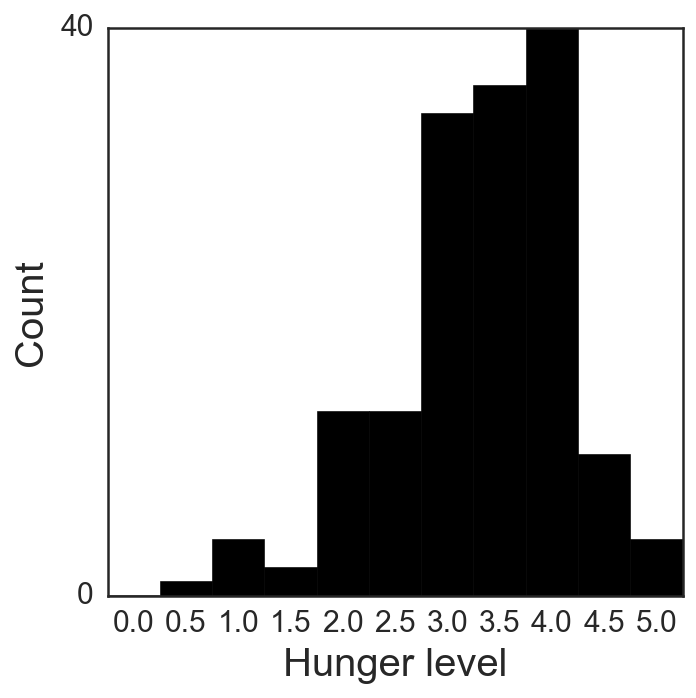

In [6]:
# Distribution of hunger level
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Hunger,np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=15)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

6.85560509554


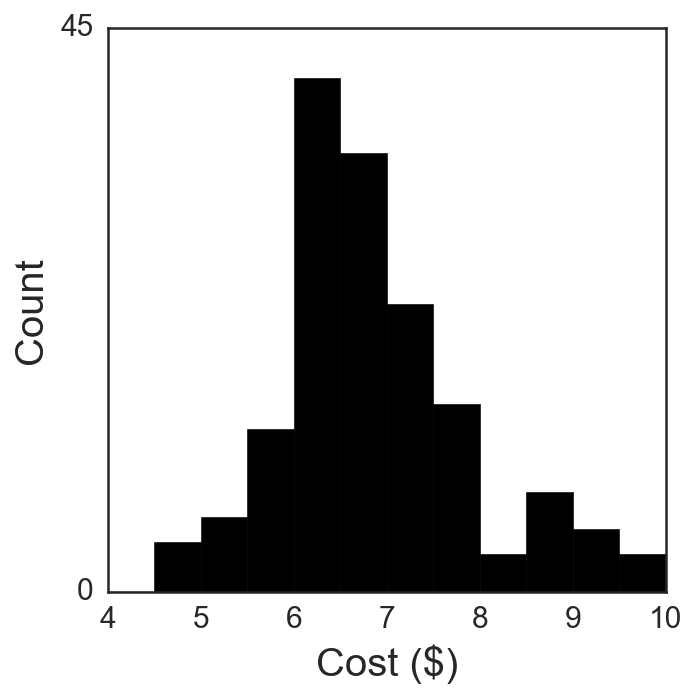

In [13]:
# Average burrito cost
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Cost,np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Cost)

0.788421052632


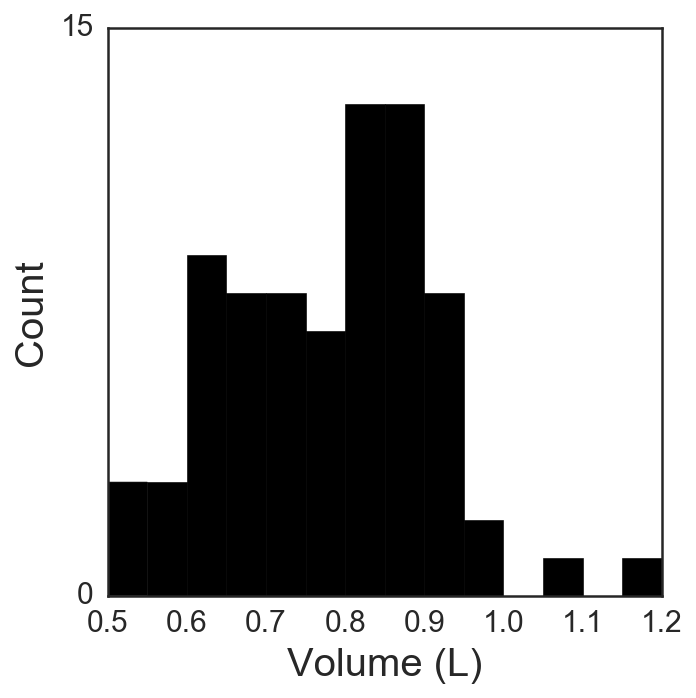

In [15]:
# Volume dist
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.5,1.3,.05),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.5,1.3,.1),size=15)
plt.xlim((0.5,1.2))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'volumedist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Volume)

In [9]:
def metrichist(metricname):
    plt.figure(figsize=(5,5))
    n, _, _ = plt.hist(df[metricname].dropna(),np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

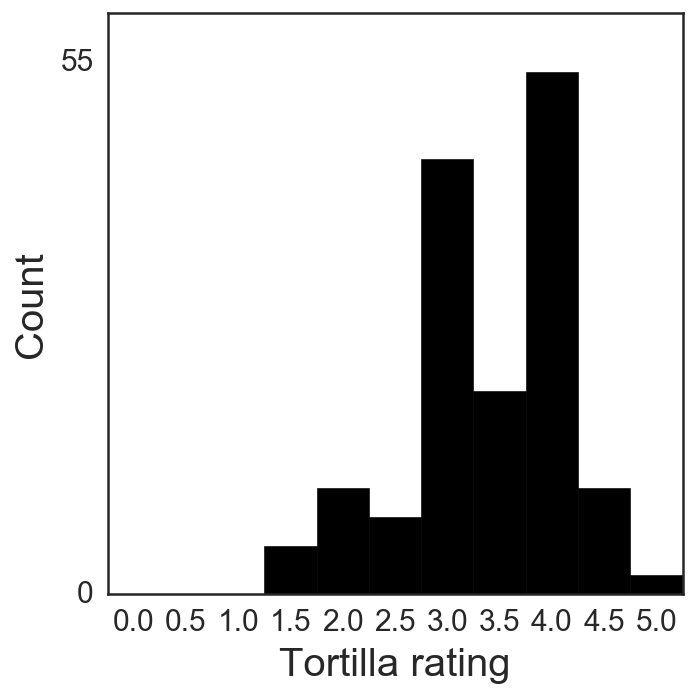

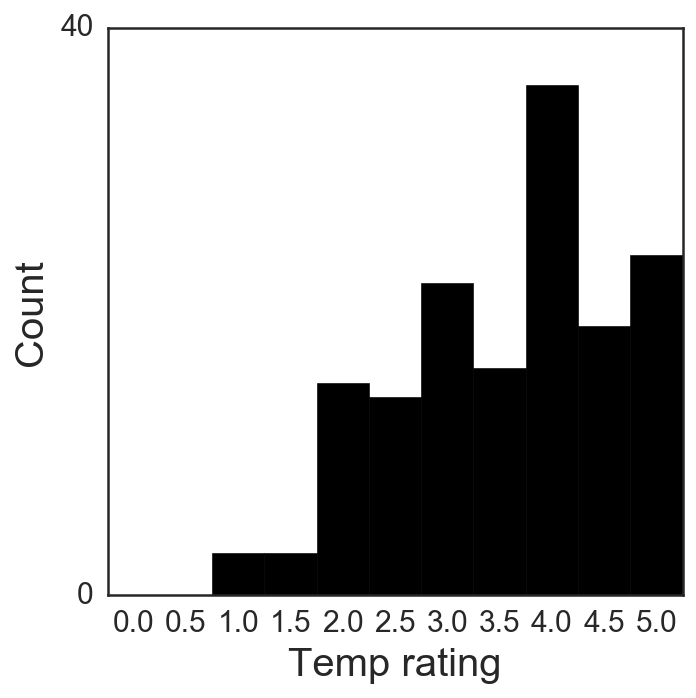

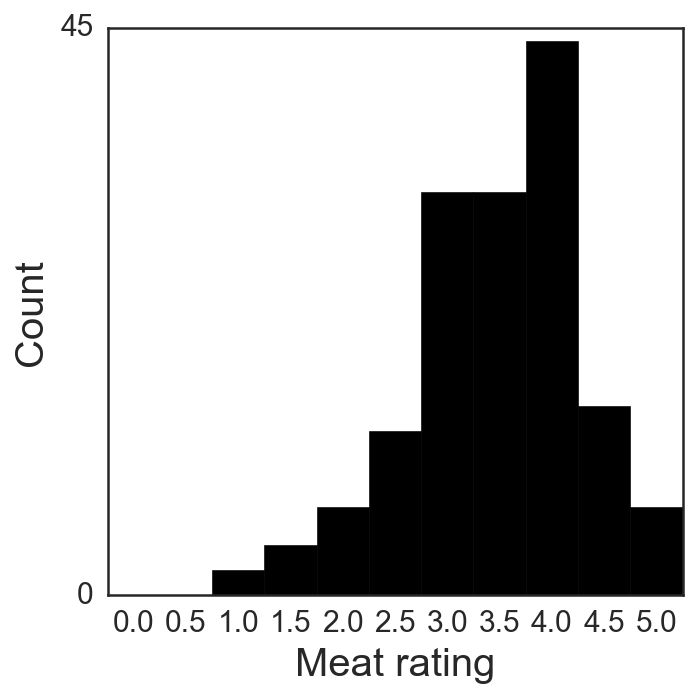

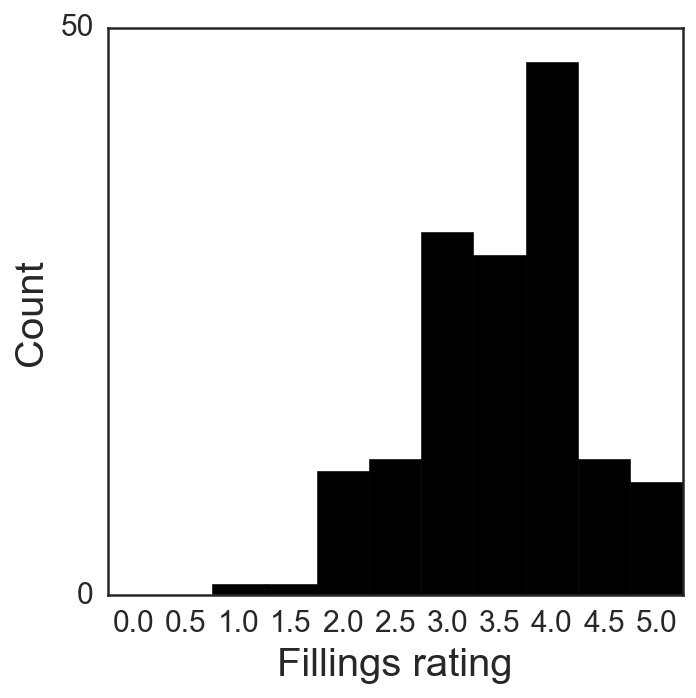

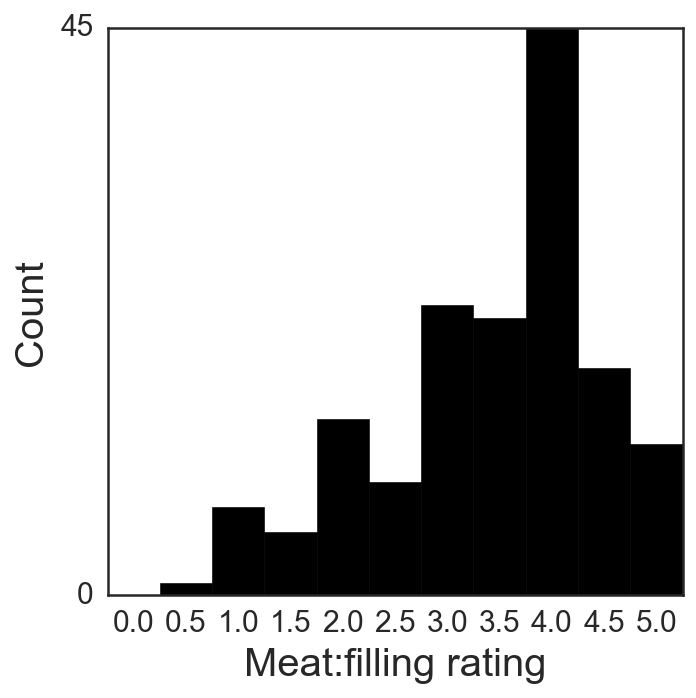

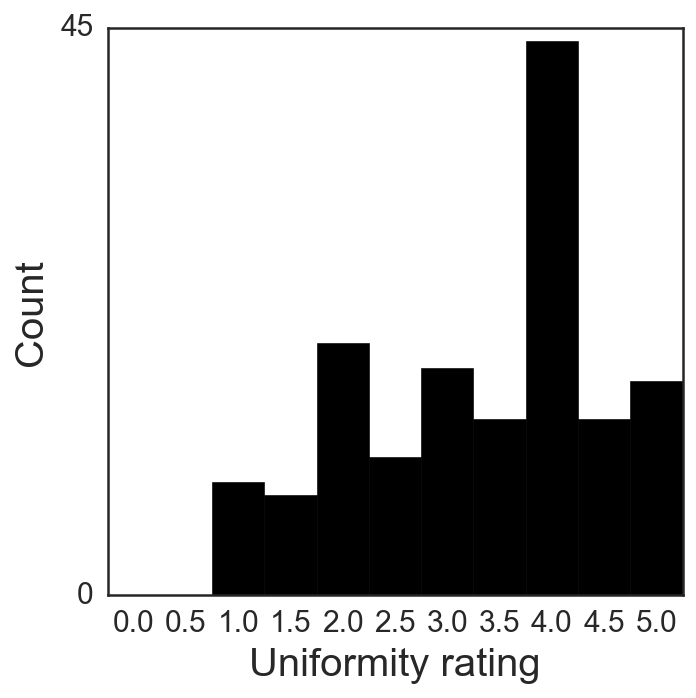

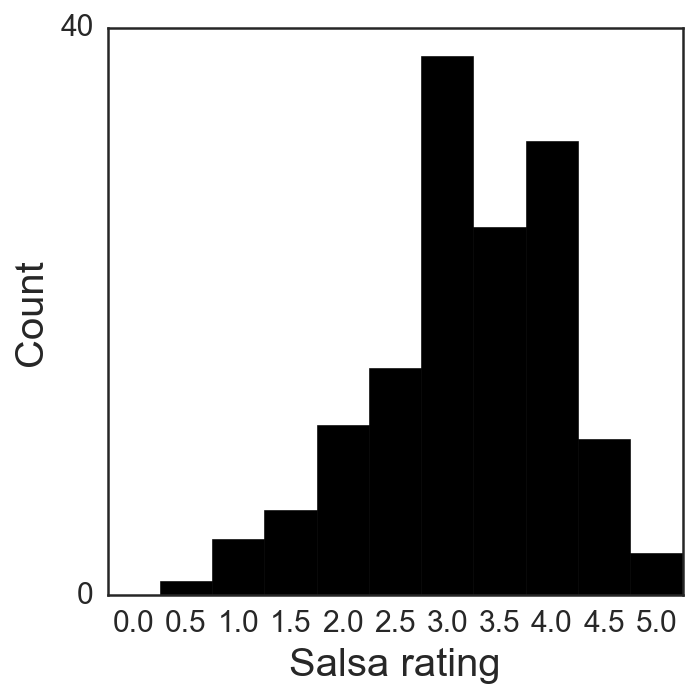

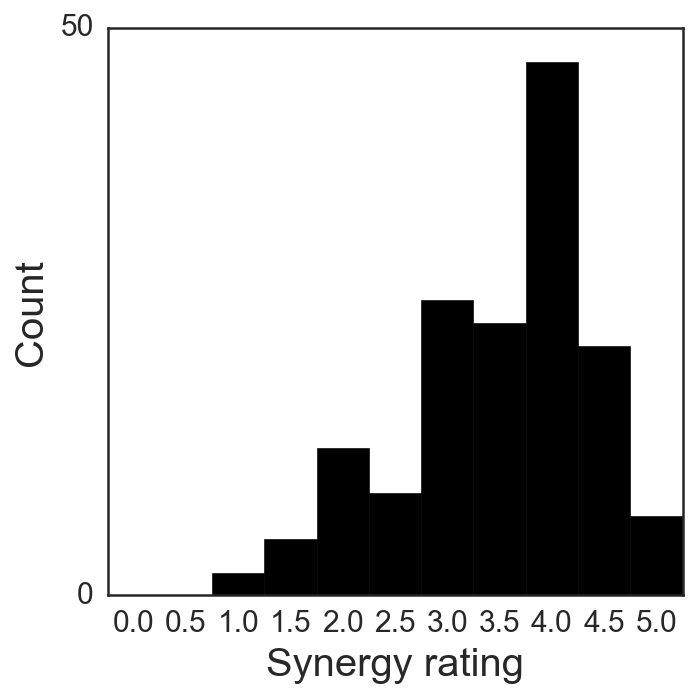

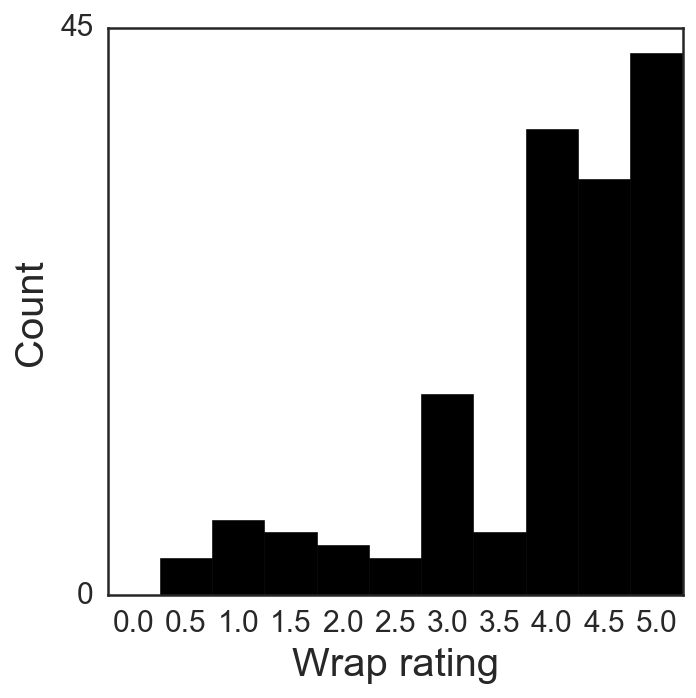

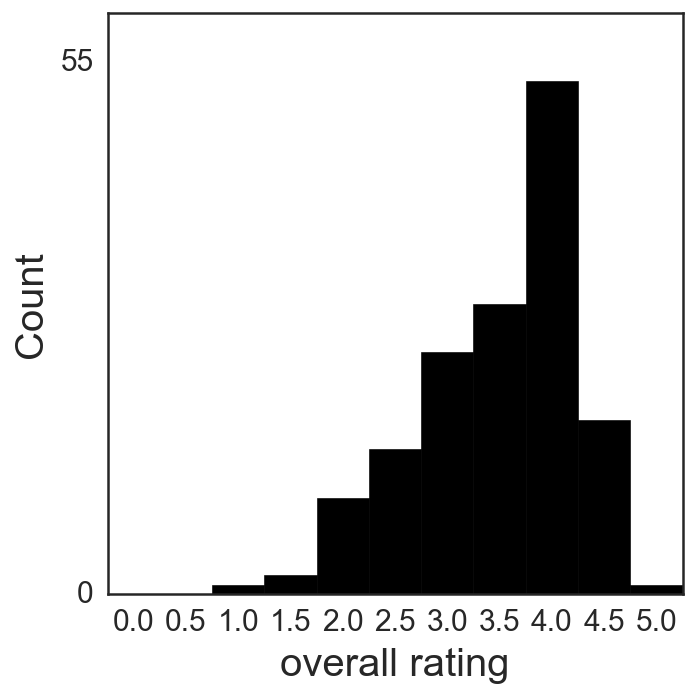

In [10]:
m_Hist = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in m_Hist:
    metrichist(m)

# Fraction of burritos recommended

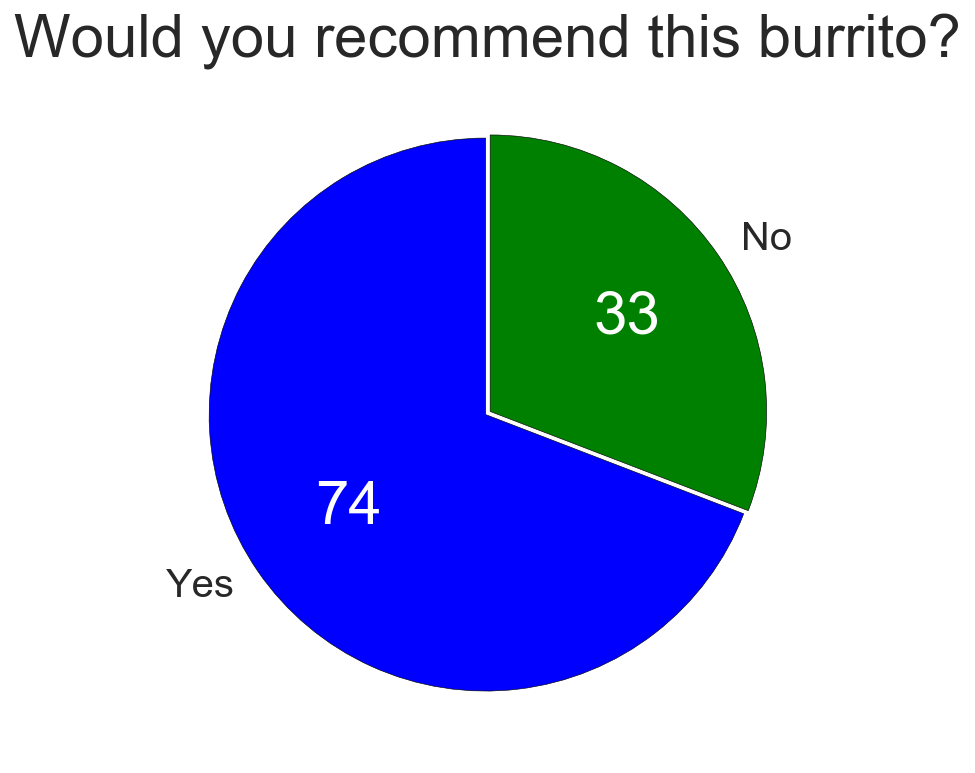

In [11]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')